Final project

Group of at most 3 people

1. pick a data set and expalin what you want to predict
2. Clean the data, Scale it
3. Plot the data with PCA, and also with each features, and see if prediction would be possible
4. Remove correlated features
5. Test all the models and pick the best one (One of the same 5 train/test split - so you make 5 different X_train, X_test) and plot the results. Only use cross_validate to find
the best number of neighbors
6. Test the best model on another split with confusion matrix and plot, which features is important.
7. Train on the whole set with the best model and predict values you pick
8. Try an ensemble model and compare it to the best model
ensemble model - pick multiple models that predict something, and do the average/linear regression on those model's results

proj due december 1st

points for cleanliness

plots explaining dataset, how it looks, features, what you predict, clean it

find best mode, conf matrix

the more complex dataset, the more points its worth

same split, for cross validate

try to do a model we have not done

want boundary plot, feature importance

cares more about explanation than model or accuracy

remove nulls, if you can't pick the medians

convert yes/no strings to 0/1

know group and dataset before break

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from os import path
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [11]:
base_url = "https://www.airlinequality.com/airline-reviews/delta-air-lines"
pages = 20
page_size = 100

#req indicates required, opt indicates optional
#star indicates review is in the form of stars
#d indicates done - it is scraped
reviews = []#req d
ratings = []#req d
aircraft = []#opt d
type_of_traveller = []#req d
cabin_flown = []#req d
route = []#req d
date_flown = []#req d
seat_comfort = []#req star d
cabin_staff_service = []#req star d
food_and_beverages = []#opt star d
inflight_entertainment = []#opt star d
ground_service = []#req star d
wifi_and_connectivity = []#opt star d
value_for_money = []#req star
recommended = []#req yes or no d

#used below
def get_proper_cell_content(type : str, mode : str = "text"):
    cell = review_table.find("td", {"class": type})
    if(mode == "text"):
        if(cell):#if the cell is found
            return cell.find_next("td").get_text()
        else:
            return None
    elif(mode == "star"):
        if(cell):#if the cell is found
            next_cell = cell.find_next("td")
            count = 0
            for filled_star in next_cell.find_all("span", {"class": "fill"}):
                count += 1
            return int(count)
        else:
            return None


for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)
    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
        
    for review_raw in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(review_raw.get_text())
    for rating in parsed_content.find_all("span", {"itemprop": "ratingValue"}):
        ratings.append(rating.get_text())
    for review_table in parsed_content.find_all("table", {"class": "review-ratings"}):
            aircraft.append(get_proper_cell_content("aircraft"))
            
            type_of_traveller.append(get_proper_cell_content("type_of_traveller"))
            
            cabin_flown.append(get_proper_cell_content("cabin_flown"))
            
            route.append(get_proper_cell_content("route"))
            
            date_flown.append(get_proper_cell_content("date_flown"))
            
            seat_comfort.append(get_proper_cell_content("seat_comfort", mode="star"))
            
            cabin_staff_service.append(get_proper_cell_content("cabin_staff_service", mode="star"))
            
            food_and_beverages.append(get_proper_cell_content("food_and_beverages", mode="star"))
            
            inflight_entertainment.append(get_proper_cell_content("inflight_entertainment", mode="star"))
            
            ground_service.append(get_proper_cell_content("ground_service", mode="star"))
            
            wifi_and_connectivity.append(get_proper_cell_content("wifi_and_connectivity", mode="star"))
            
            value_for_money.append(get_proper_cell_content("value_for_money", mode="star"))
            
            recommended.append(get_proper_cell_content("recommended"))
            
            
    print(f"   ---> {len(reviews)} total reviews")



def delete_at_intervals(list_in, interval = page_size):
    current_length = len(list_in)
    for i in range((int)(current_length / interval)):
        del list_in[i * interval]


#clean up extra content - there is an invisible rating table somewhere on the page, so every first table needs to be skipped/deleted
delete_at_intervals(ratings)
delete_at_intervals(type_of_traveller)
delete_at_intervals(aircraft)
delete_at_intervals(cabin_flown)
delete_at_intervals(route)
delete_at_intervals(date_flown)
delete_at_intervals(seat_comfort)
delete_at_intervals(cabin_staff_service)
delete_at_intervals(food_and_beverages)
delete_at_intervals(inflight_entertainment)
delete_at_intervals(ground_service)
delete_at_intervals(wifi_and_connectivity)
delete_at_intervals(value_for_money)
delete_at_intervals(recommended)


Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews
Scraping page 11
   ---> 1100 total reviews
Scraping page 12
   ---> 1200 total reviews
Scraping page 13
   ---> 1300 total reviews
Scraping page 14
   ---> 1400 total reviews
Scraping page 15
   ---> 1500 total reviews
Scraping page 16
   ---> 1600 total reviews
Scraping page 17
   ---> 1700 total reviews
Scraping page 18
   ---> 1800 total reviews
Scraping page 19
   ---> 1900 total reviews
Scraping page 20
   ---> 2000 total reviews


In [24]:
#build the data frame
df = pd.DataFrame()
df["rating"] = ratings
df["aircraft"] = aircraft
df["type_of_traveller"] = type_of_traveller
df["cabin_flown"] = cabin_flown
df["route"] = route
df["date_flown"] = date_flown
df["seat_comfort"] = seat_comfort
df["seat_comfort"] = df["seat_comfort"].astype('Int64') #int conversion
df["cabin_staff_service"] = cabin_staff_service
df["cabin_staff_service"] = df["cabin_staff_service"].astype('Int64') #int conversion
df["food_and_beverages"] = food_and_beverages
df["food_and_beverages"] = df["food_and_beverages"].astype('Int64') #int conversion
df["inflight_entertainment"] = inflight_entertainment
df["inflight_entertainment"] = df["inflight_entertainment"].astype('Int64') #int conversion
df["ground_service"] = ground_service
df["ground_service"] = df["ground_service"].astype('Int64') #int conversion
df["wifi_and_connectivity"] = wifi_and_connectivity
df["wifi_and_connectivity"] = df["wifi_and_connectivity"].astype('Int64') #int conversion
df["value_for_money"] = value_for_money
df["value_for_money"] = df["value_for_money"].astype('Int64') #int conversion
df["recommended"] = recommended

df["reviews"] = reviews
df[["verified", "review"]] = df["reviews"].str.split("|", expand=True)
df = df.drop(columns=["reviews"])
df["recommended"] = df.recommended.replace({"no": 0, "yes" : 1})
df["verified"] = df.verified.replace({"Not Verified": 0, "✅ Trip Verified": 1})

In [35]:
#drop a bad row
df = df.drop([730], axis='index')
df = df.reset_index(drop=True)

In [36]:
# df.to_csv("reviews.csv")
#uncommenting this will overwrite the previous csv, do with care

Initial analysis

<Figure size 1000x1000 with 0 Axes>

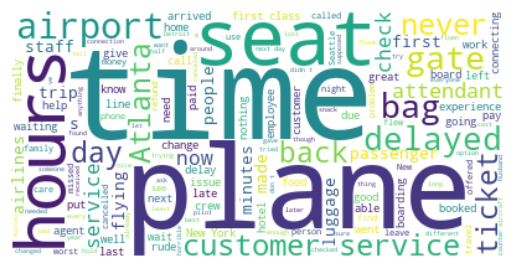

<Figure size 1000x1000 with 0 Axes>

In [42]:
text = " ".join(review for review in df.review)

stopwords = set(STOPWORDS)
stopwords.update(["flight", "Delta", "one", "told", "took", "said", "two", "make", "given", "minute",
                  "asked", "still", "way", "hour", "will", "really", "u", "got", "without", "say", "better", "take",
                  "overall", "much", "return", "fly", "us", "even", "go", "getting", "airline", "flights", "another"])

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=[10,10])